In [47]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [49]:
#import alpaca 
import alpaca_trade_api as tradeapi

In [50]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [51]:
# Set the list of tickers
tickers = ["SPY", "AGG"]

# Set timeframe to 1 DAY for close at end of each day
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for SPY,AGG
ticker_df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Use the `drop` function to get only close price of SPY AGG
ticker_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
ticker_df

,AGG,SPY
,close,close
time,,
2019-11-15 00:00:00-05:00,112.4100,311.82
2019-11-18 00:00:00-05:00,112.5950,312.00
2019-11-19 00:00:00-05:00,112.7100,311.91
2019-11-20 00:00:00-05:00,112.9700,310.79
2019-11-21 00:00:00-05:00,112.8131,310.29
...,...,...
2020-04-03 00:00:00-04:00,115.0000,248.21
2020-04-06 00:00:00-04:00,115.5800,264.97


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [52]:
# Calculate the daily roi for the stocks
# Use the `pct_change` function to calculate daily returns of `SPY` and `AGG`.
daily_returns = ticker_df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-11-15 00:00:00-05:00,NaN,NaN
2019-11-18 00:00:00-05:00,0.001646,0.000577
2019-11-19 00:00:00-05:00,0.001021,-0.000288
2019-11-20 00:00:00-05:00,0.002307,-0.003591
2019-11-21 00:00:00-05:00,-0.001389,-0.001609


In [53]:
#Calculate average daily return for each stock 
#These will be used in Monte Carlo Simulation
avg_daily_return_AGG = daily_returns.mean()['AGG']['close']
avg_daily_return_SPY = daily_returns.mean()['SPY']['close']

In [54]:
# Calculate the standard deviation of daily returns for AGG and SPY
#These will be used in Monte Carlo Simulation
std_dev_daily_return_AGG = daily_returns.std()['AGG']['close']
std_dev_daily_return_SPY = daily_returns.std()['SPY']['close']

In [55]:
# Portfolio Daily Returns
#weights show 40% AGG in portfolio and 60% SPY in portfolio
weights = [0.4, 0.6]
portfolio_daily_returns = daily_returns.dot(weights)
portfolio_daily_returns.head()

time
2019-11-15 00:00:00-05:00         NaN
2019-11-18 00:00:00-05:00    0.001005
2019-11-19 00:00:00-05:00    0.000235
2019-11-20 00:00:00-05:00   -0.001232
2019-11-21 00:00:00-05:00   -0.001521
dtype: float64

In [56]:
# Calculate volatility of AGG and SPY
volatility = daily_returns.std() * np.sqrt(252)
volatility

AGG  close    0.134605
SPY  close    0.475250
dtype: float64

In [57]:
# Save the last day's closing price
AGG_lastclose=ticker_df["AGG"]["close"][-1]
SPY_lastclose=ticker_df["SPY"]["close"][-1]

In [58]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [59]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_AGG_prices = [AGG_lastclose]
    simulated_SPY_prices = [SPY_lastclose]
    
    # Simulate the returns for 252 trading days * 30 years = 7650 days of closing prices
    for day in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
       
        # Add the simulated price to the list of prices
        simulated_AGG_prices.append(simulated_AGG_price)
        simulated_SPY_prices.append(simulated_SPY_price)
    
    # Add simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_AGG_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_SPY_prices)  
    
    # Calculate the daily returns of simulated prices
    monte_carlo_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY;)
    weights = [0.4, 0.6]
    
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    #This will give appropriate weight to the returns from each stock
    portfolio_returns = monte_carlo_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n]= (1 + portfolio_returns.fillna(0)).cumprod()
    
# Print records from the DataFrame
portfolio_cumulative_returns

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998959,0.998898,0.992192,1.017623,1.042333,0.976115,0.986911,1.047602,1.000420,0.979324,...,1.005010,0.968991,1.004208,1.007229,0.983451,1.009227,1.003126,1.022753,0.990172,0.976915
2,1.028242,1.011971,1.007365,0.980972,1.030610,0.972075,0.972267,1.020017,0.994955,0.967957,...,1.016258,0.973150,1.007159,1.017777,0.984354,0.962326,1.004432,1.014331,0.979511,0.989568
3,1.022852,1.007149,1.005209,0.983540,1.020421,0.944739,0.984534,0.994134,0.992005,0.996106,...,1.017146,0.947658,1.007430,1.031758,0.965402,0.969352,1.022683,0.987403,0.986196,1.003451
4,1.042184,1.013270,1.020140,0.997433,1.040326,0.953805,1.000447,0.968796,0.996272,1.010813,...,1.004263,0.958249,1.006698,1.004950,0.968538,0.963845,1.009521,0.996218,0.977067,1.003544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,0.044081,0.029835,0.030957,0.011831,0.030845,0.768857,0.004168,0.058336,0.033967,0.019248,...,0.054488,0.060567,0.050980,0.017233,0.064498,0.891533,0.030100,1.256208,0.011573,0.055230
7557,0.043594,0.028614,0.030556,0.011790,0.030998,0.766055,0.004059,0.060108,0.033920,0.018625,...,0.054031,0.059690,0.051454,0.016656,0.064438,0.912746,0.030287,1.269492,0.011680,0.054643
7558,0.042954,0.028402,0.031004,0.011824,0.030510,0.776358,0.004056,0.060840,0.034429,0.018604,...,0.054027,0.060230,0.051961,0.016425,0.065455,0.910568,0.030219,1.229815,0.011326,0.054887
7559,0.042517,0.028257,0.031089,0.011908,0.031463,0.759598,0.004007,0.060317,0.033582,0.018486,...,0.054258,0.061220,0.050618,0.016394,0.066638,0.900344,0.030313,1.213841,0.011036,0.053825


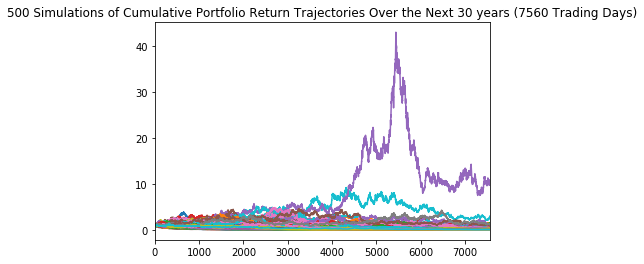

In [60]:
# Visualize the Simulation
# Use the `plot` function to plot 500 simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 years (7560 Trading Days)"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [61]:
# Select the last row for the cumulative returns (cumulative returns at 30 years or 7560 trading days )
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.044014
1    0.028767
2    0.032268
3    0.012111
4    0.031504
Name: 7560, dtype: float64

In [62]:
# Select the last row for the cumulative returns (cumulative returns at 20 years or 5040 trading days)
yr20_cumulative_returns = portfolio_cumulative_returns.iloc[5041, :]
yr20_cumulative_returns.head()

0    0.123378
1    0.094313
2    0.060740
3    0.040125
4    0.468611
Name: 5041, dtype: float64

In [79]:
# Display the 90% confidence interval for the ending returns
# Use the quantile function to calculate the 90% confidence interval for simulated ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    0.003918
0.95    0.577752
Name: 7560, dtype: float64

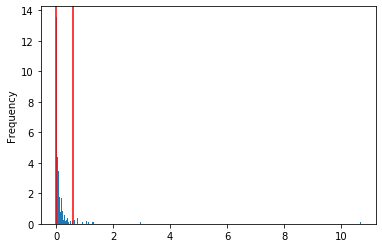

In [83]:
# Visualize the distribution of the ending returns
# Create a probability distribution histogram of simulated ending prices
# with markings for a 90% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=500)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [65]:
#bring down ending_cumulative_returns for the last row of monte_carlo data @ 30 years or 7650 trading days

# Display the 90% percentile for the ending returns
# Use the quantile function to calculate the 90% percentile for simulated ending returns
percentile_90 = ending_cumulative_returns.quantile(q=0.9)
percentile_90

0.3033626226011421

In [66]:
# Display the 50% percentile for the ending returns
# Use the quantile function to calculate the 50% percentile for simulated ending returns
percentile_50 = ending_cumulative_returns.quantile(q=0.5)
percentile_50

0.04864597347689583

In [67]:
# Display the 10% percentile for the ending returns
# Use the quantile function to calculate the 10% percentile for simulated ending returns
percentile_10 = ending_cumulative_returns.quantile(q=0.1)
percentile_10

0.006717658109412721

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [68]:
# Set initial investment
initial_investment = 20000

In [69]:
#90th percentile
investment_pnl_90 = initial_investment+(initial_investment * percentile_90)

# Print the results
print(f"The expected return at the 90th percentile for the initial investment of ${initial_investment} in the portfolio"
      f" over the next 252 * 30 trading days is"
      f" ${investment_pnl_90}")

The expected return at the 90th percentile for the initial investment of $20000 in the portfolio over the next 252 * 30 trading days is $26067.25245202284


In [70]:
# For the 50th Percentile
investment_pnl_50 = initial_investment+(initial_investment * percentile_50)

# Print the results
print(f"The expected return at the 50th percentile for the initial investment of ${initial_investment} in the portfolio"
      f" over the next 252 * 30 trading days is"
      f" ${investment_pnl_50}")

The expected return at the 50th percentile for the initial investment of $20000 in the portfolio over the next 252 * 30 trading days is $20972.919469537916


In [71]:
# For the 10th Percentile
investment_pnl_10 = initial_investment+(initial_investment * percentile_10)

# Print the results
print(f"The expected return at the 10th percentile for the initial investment of ${initial_investment} in the portfolio"
      f" over the next 252 * 30 trading days is"
      f" ${investment_pnl_10}")

The expected return at the 10th percentile for the initial investment of $20000 in the portfolio over the next 252 * 30 trading days is $20134.353162188254


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [72]:
#Will 4% withdraw rate from retirement meet or exceed value at the 10th percentile.
#4% withdraw from retirement portfolio value vs. income estimated in plaid. 
proj_annual_income=6085
#Calculate 4% of the retirement portfolio value at the 10th percentile
retirement_10_4percent=investment_pnl_10*(4/100)

print(f"A 4% withdraw rate from the 10th percentile retirement portfolio is ${retirement_10_4percent} at 30 years. This value is lower than the projected yearly income of ${proj_annual_income}. This means that for the 10th percentile value the withdraw from the portfolio will not meet and will not exceed the value of the projected annual income. This portfolio will not provide adequate retirement income at that withdrawl rate to meet current annual income/living expectations.")

A 4% withdraw rate from the 10th percentile retirement portfolio is $805.3741264875301 at 30 years. This value is lower than the projected yearly income of $6085. This means that for the 10th percentile value the withdraw from the portfolio will not meet and will not exceed the value of the projected annual income. This portfolio will not provide adequate retirement income at that withdrawl rate to meet current annual income/living expectations.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [73]:
# Set initial investment to 1.5 x more (50% increase)
initial_investment_raised = 20000*1.5
# For the 10th Percentile
investment_pnl_10_raised = initial_investment_raised+(initial_investment_raised * percentile_10)

# Print the results
print(f"For a 50% higher initial investment of ${initial_investment_raised} in the portfolio"
      f" over the next 252 * 30 trading days the 10th percentile net value is"
      f" ${investment_pnl_10_raised}")

For a 50% higher initial investment of $30000.0 in the portfolio over the next 252 * 30 trading days the 10th percentile net value is $30201.529743282383


In [74]:
#Will 4% withdraw rate from retirement meet or exceed value at the 10th percentile.
#4% withdraw from retirement portfolio value vs. income estimated in plaid. 
#Project yearly income was $6085 
#Calculated in account_summary.ipynb
proj_annual_income=6085
#Calculate 4% of the retirement portfolio value at the 10th percentile
retirement_raised_10_4percent=investment_pnl_10_raised*(4/100)

print(f"A 4% withdraw rate from the retirement portfolio for the 10th percentile will be ${retirement_raised_10_4percent}. This value is still lower than the projected yearly income of ${proj_annual_income}. This means that the withdraw from the portfolio will not meet and will not exceed the value of the projected annual income. Even with more initial investment, this portfolio will not provide adequate retirement income at that withdrawl rate to meet current annual income/living expectations.")

A 4% withdraw rate from the retirement portfolio for the 10th percentile will be $1208.0611897312954. This value is still lower than the projected yearly income of $6085. This means that the withdraw from the portfolio will not meet and will not exceed the value of the projected annual income. Even with more initial investment, this portfolio will not provide adequate retirement income at that withdrawl rate to meet current annual income/living expectations.


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [75]:
# YOUR CODE HERE